In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress

# Atmospheric Prioritization

The goal of this code is to find planets which are good candidates for atmospheric follow-up. We are particularly interested in planets which are from poorly-covered regions of parameter space (e.g., smaller than previously-known planets, or around different types of star, or with more/less irradiation). Because the code was developed for TESS planets, we impose a cutoff at 11.2 R_e. If you change that, beware of the breakdown of the empirical mass-radius relationship for larger planets; you will need to implement a statistical model, e.g. mr_forecaster by Chen & Kipping 2017. 

In [2]:
from priority_tools import *

# Loading the Necessary Data

The first thing to do is get all the data set up. You need to load in the toi+ list (data/toi/toi+-...), where ... is the date of the most recent data release. If you are curious about previous releases, some of them are also in that directory. You also need the TIC star info, which has V, J, and K magnitudes that are missing from TOI+. 

In [3]:
#generate the key names for all the TOI+ columns we need.
#see column_key_names.txt for what these are
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

#load the TOI+ list
toiplus = pd.read_csv('data/toi/toi+-2020-02-20.csv',
                      delimiter=',',header=4)

#load the TIC star info
TIC_info = pd.read_csv('data/exofop/TIC_star_info_2020-02-20.csv',
                       delimiter=',',header=10)

#run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, include_qlp=False)

#load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
d = tess.append(kps[np.logical_and(kps['K_amp'] > 1.5, kps['TSM'] > 10)],sort=False) 
    #the K_amp cut wasn't made in the data itself, but is 
    #necessary to cut some of those not-real long-period
    #KOIs as well as known planets for which we can't get masses

# Binning

With all the data loaded, we can run the binning function and generate the pandas dataframe object that we can use for the rest of the analysis. This function has the longest runtime of anything here; it may take a minute or two without a speedy computer. 

In [4]:
#defining the bins: log-uniform in radius and Fp, 
#uniform in Teff. Right now, you need 6 bin edges
#for radius and Fp and 4 for Teff; we can change
#that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1,6)) 
rad_bins[-1] = 11.2 #want to include up to Jupiter radius 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

b = binning_function(d, bins) #b stands for "binned", 
                            #to make use easier

# Playing With The Data

Now, we can start looking at the data! Two very simple things we might want to do are look at a single TOI, and look at it in the context of its bin. If you've used pandas before, messing around with these data will be straightforward; if not, here are some useful tricks. To load a single object, use: b[b[id_key] == x], where x is the ID number including .01 or .02 (or .03, or whichever planet you want if it's a highly multiple system). If you want to learn about a known planet instead, x is a string of the form "{name} {letter}", e.g. "GJ 1214 b".

In [5]:
#make sure we can see the columns in the middle of the output
pd.options.display.max_columns = 100 

#call the request
#b[b[id_key]=='K2-182 b']
b[b[id_key]==1728.01]
#the output tells us which radius, insolation, and Teff bin 
#the target is in, aswell as all the data from the TOI plus 
#list and values that we've calculated

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,3,2,spoc,285048486.0,1728.01,120.610626,64.796925,10.7921,0.007245,1843.274889,0.000591,3.491567,0.000141,1.890422,0.083425,5520.476437,110.440475,20,NaN,4.62346,0.011365,1.0,0.633154,0.018702,4.699432,0.3616,700.851229,3907.0,157.0,57.019625,36.222485,NaN,2020-02-19 23:47:13+0000,2020-02-19 23:47:13+0000,0.613913,19.935704,13.004757,11.65389,285048486.0,120.611679,64.797153,12.39,9.642,8.953,8.803001,134.915225,NaN,4,3,2,1.0


In [6]:
#you can also ask for a few specific columns if you want 
#a much less messy output: we'll call these "uks" for 
#useful keys, which you can feel free to modify as you
#see fit
uks = [rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','TSM','priority', 'Full TOI ID', 'Planet Equilibrium Temperature (K) Value']
b[b[id_key] == 'K2-182 b'][uks]

,,,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,TSM,priority,Full TOI ID,Planet Equilibrium Temperature (K) Value
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,
3,4,2,2.76,4.736837,5165.0,145.83314,41.834229,11.997,10.408,41.834229,0.0,K2-182 b,NaN


In [13]:
k2_182_row = b[b[id_key] == 'K2-182 b']
T_eff_k2_182 = k2_182_row['Effective Temperature Value']
ar_k2_182 = ars_from_t(k2_182_row['Orbital Period Value'], k2_182_row['Stellar Mass'], k2_182_row['Star Radius Value'])
Teq_k2_182 = b[b[id_key] == 'K2-182 b']['Effective Temperature Value'] * (np.sqrt(1/ar_k2_182)*(0.25**0.25))

To look at an entire bin, use b.loc[x,y,z], where x, y, and z are the radius, insolation, and Teff bin, respetively. Note that these are 1-indexed, not 0-indexed (sorry). If it's priority values alone you're interested in, scroll all the way to the right. 

In [8]:
#look into this bin, and select only the top 5 (by TSM)
b.loc[4,3,2][uks].head(10)

Planet Radius Value  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
4          3         2                       4.360000              4.887802   
                     2                       4.699432              3.491567   
                     2                       5.611109              2.326811   
                     2                       4.012561              4.897647   
                     2                       4.420000             11.716332   
                     2                       4.000000              6.010384   
                     2                       5.110000              5.424749   
                     2                       5.500000              5.907414   
                     2                       4.920000             11.128305   
                     2                       4.456759             10.691098   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
4          3         2                                4780.00   
                     2                                3907.00   
                     2                                3946.00   
                     2                                4528.99   
                     2                                5200.00   
                     2                                4828.00   
                     2                                4188.00   
                     2                                4963.00   
                     2                                4094.00   
                     2                                4067.00   

                                  Effective Stellar Flux Value         TSM  \
radius_bin insol_bin st_Teff_bin                                             
4          3         2                               78.335002  292.993601   
                     2                               57.019625  134.915225   
                     2                               89.326441   89.573126   
                     2                               95.044646   80.242179   
                     2                               48.646997   25.044377   
                     2                               73.139170   22.548888   
                     2                               36.939553   19.932975   
                     2                               86.022970   17.078814   
                     2                               11.203229   12.462160   
                     2                               20.000337         NaN   

                                    V mag   J mag         TSM  priority  \
radius_bin insol_bin st_Teff_bin                                          
4          3         2                NaN   7.608  292.993601       3.0   
                     2            12.3900   9.642  134.915225       1.0   
                     2            14.4130  11.466   89.573126       2.0   
                     2            11.3080   9.586   80.242179       0.0   
                     2            13.3710  11.811   25.044377       0.0   
                     2                NaN  12.588   22.548888       0.0   
                     2                NaN  14.101   19.932975       0.0   
                     2                NaN  14.061   17.078814       0.0   
                     2                NaN  14.832   12.462160       0.0   
                     2            12.5001     NaN         NaN       0.0   

                                    Full TOI ID  \
radius_bin insol_bin st_Teff_bin                  
4          3         2               HAT-P-11 b   
                     2                  1728.01   
                     2                   532.01   
                     2                  1424.01   
                     2                 K2-273 b   
                     2             Kepler-547 b   
                     2            Kepler-1314 b   
       

# Visualization Tool

Let's try the visualization tool, which displays all the high-priority objects in a given radius bin. Priority 1 is green, 2 is yellow, 3 is orange. Additionally, any planets with known transmission spectra are displayed in red (for those with observed features) or grey (for those with no observed features; note that, especially for confirmed TESS planets, observations might be very limited so "no observed features" doesn't necessarily mean cloudy). 

Dots scale linearly with planet radius. Labels indicate the object: floats are TOIs (i.e. "421.01" is TOI 421.01), anything starting with "K0" or "EPIC" is an unconfirmed KOI or K2 object, respectively, and everything else is a confirmed planet (including some previously-confirmed TOIs - for example TOI 270c falls into this category). Note that long-period KOIs (i.e., those in the top left - with relatively hot stars but earth-like insolation) are generally considered unreliable and should not automatically be assumed to actually exist or be good potential atmospheric targets. 

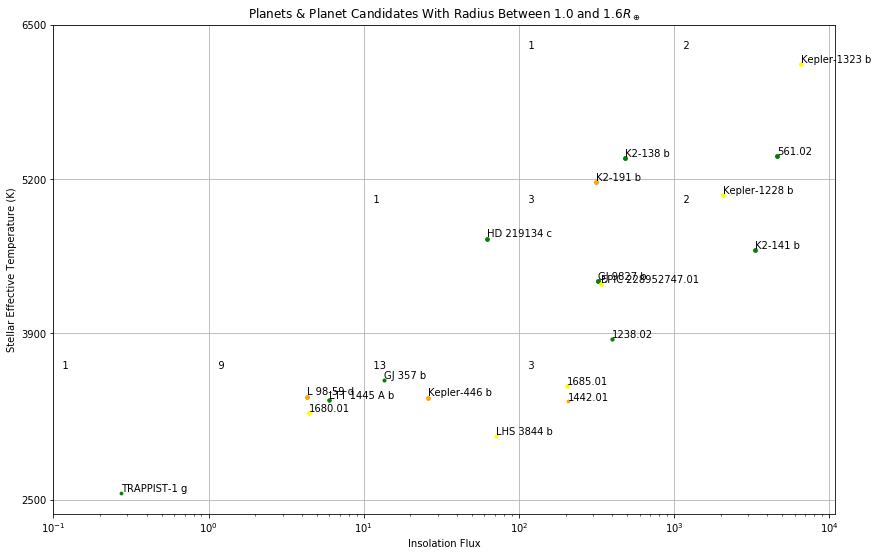

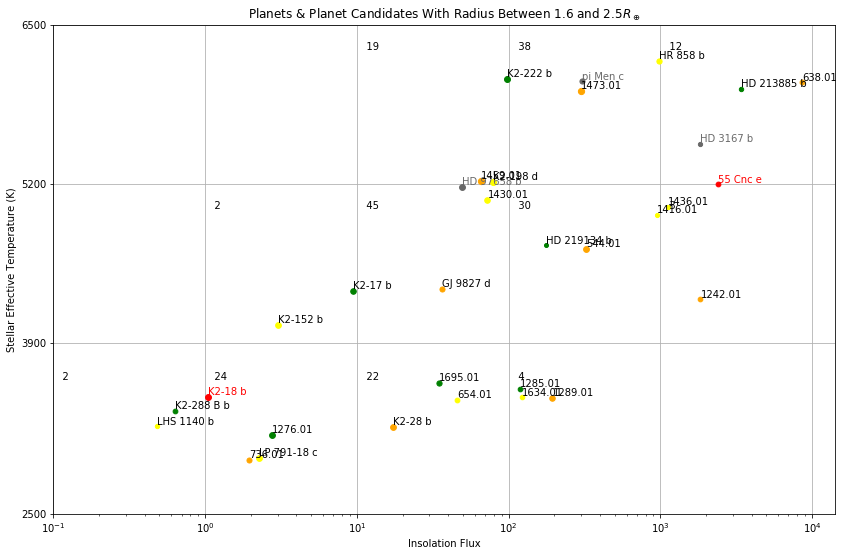

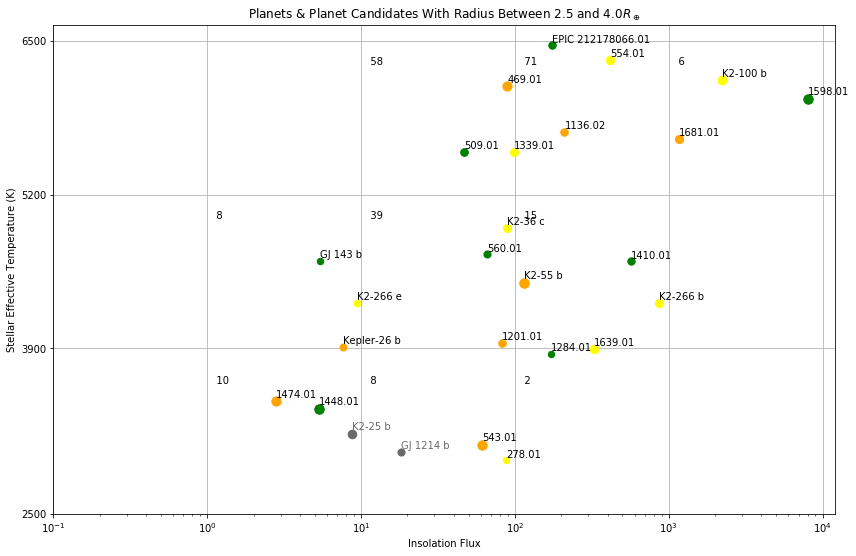

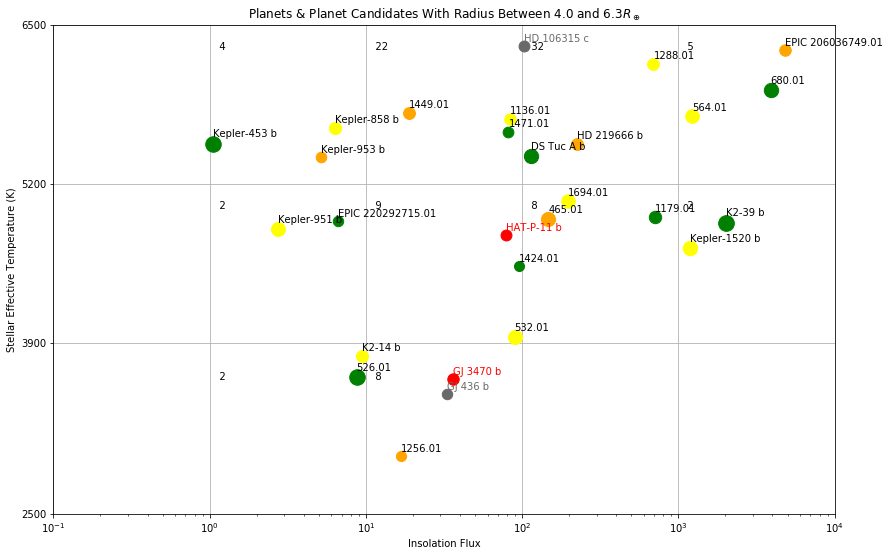

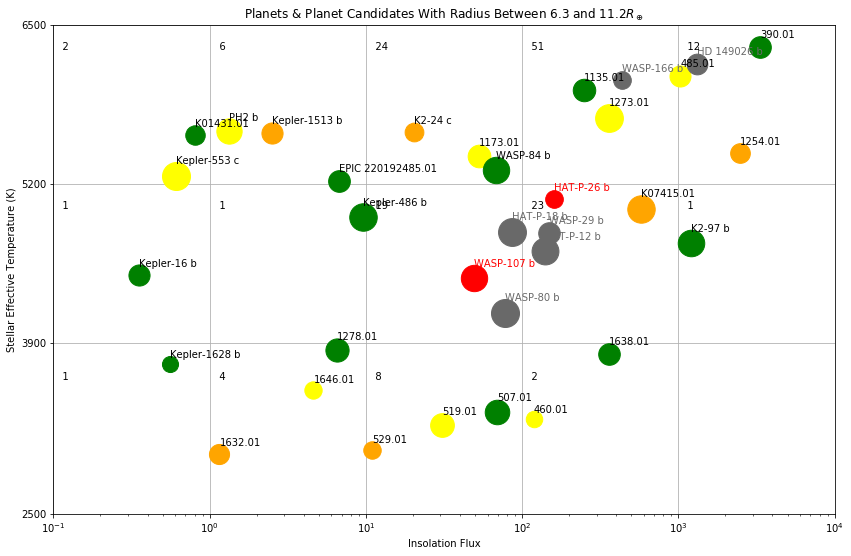

In [12]:
#bin_plotter inputs are the binned data, the bin edges
#(as defined above), and the radius bin of interest
for i in np.arange(1,6):
    bin_plotter(b,bins,i)

## Joey messing around here

I'm going to do some of my own messing around with the prioritized dataframe to get some general numbers e.g. how many TESS targets are atmospheric priroity 1 candidates.

In [ ]:
p1_df = b.loc[b['priority'] == 1.0] # All targets that have priority 1 designation
p1_TESS_df = p1_df.dropna(subset=['TIC']) # Drop targets that are not TESS i.e. don't have a TIC number
p1_TESS_df

In [ ]:
len(p1_TESS_df)